<center><h1> Recommendation Systems </h1></center>

# 1. Information

https://nijianmo.github.io/amazon/index.html  
This Dataset is an updated version of the Amazon review dataset released in 2014. As in the previous version, this dataset includes reviews (ratings, text, helpfulness votes), product metadata (descriptions, category information, price, brand, and image features), and links (also viewed/also bought graphs). 
**reviewerID** - ID of the reviewer, e.g. A2SUAM1J3GNN3B  
**asin** - ID of the product, e.g. 0000013714  
**reviewerName** - name of the reviewer  
**vote** - helpful votes of the review  
**style** - a disctionary of the product metadata, e.g., "Format" is "Hardcover"  
**reviewText** - text of the review  
**overall** - rating of the product  
**summary** - summary of the review  
**unixReviewTime** - time of the review (unix time)  
**reviewTime** - time of the review (raw)  
**image** - images that users post after they have received the product  

# 2. Fetching Data:

## 2.1 Import packages

In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sparse
import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.mlab as mlab
%matplotlib inline
import warnings
import math
pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')


In [2]:
modelRDY = False

## 2.2 Import data

In [3]:
data_orig=pd.read_json("Toys_and_Games_5.json", lines=True)

In [4]:
data = data_orig.head(int(data_orig.shape[0]/10)).copy()
data.head(5)

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5,3,True,"10 6, 2013",A2LSCFZM2FBZK7,0486427706,{'Format:': ' Paperback'},Ginger,The stained glass pages are pretty cool. And i...,Nice book,1381017600,NaN
1,5,9,True,"08 9, 2013",A3IXP5VS847GE5,0486427706,{'Format:': ' Paperback'},Dragonflies &amp; Autumn Leaves,My 11 y.o. loved this...and so do I (you know ...,Great pictures,1376006400,NaN
2,5,NaN,True,"04 5, 2016",A1274GG1EB2JLJ,0486427706,{'Format:': ' Paperback'},barbara ann,"The pictures are great , I've done one and gav...","The pictures are great, I've done one and gave...",1459814400,NaN
3,5,3,True,"02 13, 2016",A30X5EGBYAZQQK,0486427706,{'Format:': ' Paperback'},Samantha,I absolutely love this book! Its translucent p...,So beautiful!,1455321600,NaN
4,5,NaN,True,"12 10, 2015",A3U6UNXLAUY6ZV,0486427706,{'Format:': ' Paperback'},CP in Texas,I love it!,Five Stars,1449705600,NaN


Я здесь беру десятую часть датасета, поскольку при работе с полным объемом данных pandas постоянно ругается, что у него закончилась память.

In [5]:
data.shape

(182897, 12)

# 3 Data Cleaning

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182897 entries, 0 to 182896
Data columns (total 12 columns):
overall           182897 non-null int64
vote              23197 non-null object
verified          182897 non-null bool
reviewTime        182897 non-null object
reviewerID        182897 non-null object
asin              182897 non-null object
style             77061 non-null object
reviewerName      182880 non-null object
reviewText        182841 non-null object
summary           182872 non-null object
unixReviewTime    182897 non-null int64
image             2465 non-null object
dtypes: bool(1), int64(2), object(9)
memory usage: 15.5+ MB


In [7]:
data.isna().sum()

overall                0
vote              159700
verified               0
reviewTime             0
reviewerID             0
asin                   0
style             105836
reviewerName          17
reviewText            56
summary               25
unixReviewTime         0
image             180432
dtype: int64

Все необходимые признаки (**asin**, **reviewerID**, **overall**) пропусков не имеют.

## 3.1 Data Encoding

In [8]:
from sklearn import preprocessing, metrics

In [9]:
data = data.sort_values(by=['unixReviewTime'])
le = preprocessing.LabelEncoder()

Сортирую датасет по времени, чтобы соблюсти временную зависимость при построении модели.

In [10]:
data['reviewerID'] = le.fit_transform(data['reviewerID'])

In [11]:
data['asin'] = le.fit_transform(data['asin'])

In [12]:
data.reset_index(inplace=True, drop=True)

In [13]:
data.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5,53,False,"10 6, 1999",9936,68,{'Format:': ' Toy'},Michael J Woznicki,Ready for Hearts to meet Spades and Whist? Wel...,The game was a great time for everyone.,939168000,NaN
1,5,54,False,"03 8, 2000",86708,379,NaN,Soozie4Him,How long has it been since *you* had a toy? Y...,Lots of fun for grown-ups too!,952473600,NaN
2,3,9,False,"05 2, 2000",56688,362,NaN,A. Macphee,When this first came out at a price of $20(or ...,Getting better with the POTF figures,957225600,NaN
3,5,8,False,"07 28, 2000",34278,677,NaN,Zack Davisson,This was one of my favorite games when I was y...,Have fun - Learn French!,964742400,NaN
4,5,NaN,False,"07 30, 2000",34655,394,NaN,CMC,You will love Tetris DX! I had the Tetris Gold...,"Fast, furious and fun!",964915200,NaN


# 4. EDA

In [14]:
data.describe()

,overall,reviewerID,asin,unixReviewTime
count,182897.000000,182897.000000,182897.000000,1.828970e+05
mean,4.444802,49740.878959,3105.256778,1.406189e+09
std,1.018122,28629.940451,1959.910614,8.165187e+07
min,1.000000,0.000000,0.000000,9.391680e+08
25%,4.000000,24768.000000,1178.000000,1.377216e+09
50%,5.000000,49882.000000,3196.000000,1.421885e+09
75%,5.000000,74564.000000,4816.000000,1.457395e+09
max,5.000000,99268.000000,6659.000000,1.526602e+09


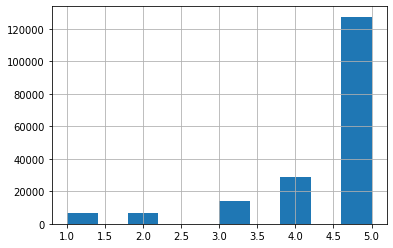

In [15]:
data.overall.hist()

# 5. Machine Learning

In [16]:
import pickle
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score

## 5.1 Data preparation 

In [17]:
customers = list(np.sort(data.reviewerID.unique())) 
products = list(data.asin.unique()) 
overall = list(data.overall.astype(np.int64))

rows = data.reviewerID.astype('category').cat.codes 
cols = data.asin.astype('category').cat.codes 

In [18]:
user_item = data.groupby(['reviewerID', 'asin'])['overall']

In [19]:
purchases_matrix = user_item.mean().unstack().fillna(0)

In [20]:
purchases_sparse = sparse.coo_matrix(purchases_matrix).tocsr()

In [21]:
# Нормирую оценки по каждому пользователю
for j in range(purchases_sparse.shape[0]):
    usr_mean_score = purchases_sparse[j,(purchases_sparse[j,:].nonzero())[1]].mean()
    for i in (purchases_sparse[j,:].nonzero())[1]:
        purchases_sparse[j,i] = (purchases_sparse[j,i])/(usr_mean_score)

In [22]:
print(len(products), len(customers), len(overall))

6660 99269 182897


In [23]:
matrix_size = purchases_sparse.shape[0]*purchases_sparse.shape[1] 
num_purchases = len(purchases_sparse.nonzero()[0]) 
sparsity = 100*(1 - (num_purchases/matrix_size))
print('Разрежённость матрицы  ', sparsity)

Разрежённость матрицы   99.97251484931425


In [24]:
purchases_sparse.shape

(99269, 6660)

In [25]:
np.isnan(np.sum(purchases_sparse))

False

Интересно, что некоторые пользователи голосовали за один и тот же товар по несколько раз. У Amozon в backend-е похоже была дырка!

## 5.2 Train test Split

In [26]:
def make_train(ratings, pct_test = 0.2):
    training_set = ratings.copy() 
    nonzero_inds = training_set.nonzero() 
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) 
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs))) 
    samples = nonzero_pairs[-num_samples::]
    user_inds = [index[0] for index in samples] 
    item_inds = [index[1] for index in samples] 
    training_set[user_inds, item_inds] = 0 
    
    test_set = ratings.copy()
    num_samples = int(np.ceil((1-pct_test)*len(nonzero_pairs))) 
    samples = nonzero_pairs[0:num_samples-1]
    user_inds = [index[0] for index in samples] 
    item_inds = [index[1] for index in samples] 
    test_set[user_inds, item_inds] = 0 
    return training_set, test_set, list(set(user_inds)) 

In [27]:
product_train, product_test, product_users_altered = make_train(purchases_sparse, pct_test = 0.2)

## 5.3 LightFM Model

In [28]:
model = LightFM(
                loss='warp-kos',
                k=10,
                random_state = 42
                )

In [29]:
if (modelRDY):
    with open('saved_model','rb') as f:
            saved_model=pickle.load(f)
            model=saved_model['model']
else:    
    model.fit(product_train,
              epochs     =100,
              num_threads=4
              )
    
    with open('saved_model','wb') as f:
                saved_model={'model':model}
                pickle.dump(saved_model, f)
        
    
train_auc = auc_score(model, product_train, num_threads=4).mean()
test_auc = auc_score(model, product_test, num_threads=4).mean()

print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))


AUC: train 1.00, test 1.00.


In [38]:
# Расчет RMSE
model_pred_scores = model.predict(product_test.nonzero()[0], product_test.nonzero()[1])
pred_scores = pd.Series(model_pred_scores).apply(lambda x: 0 if x<0 else x)
test_scores = product_test.A[product_test.nonzero()[0], product_test.nonzero()[1]]
rmse =  np.sqrt(np.mean(((test_scores-pred_scores)**2)))
print('RMSE = %.2f' % (rmse))

RMSE = 1.37


# 6. Conclusion

In [41]:
from sklearn.metrics.pairwise import cosine_similarity

def display_item_to_items_recommendations(model, item_id):

    products_arr = np.array(products) 
    
    item_id = np.where(products_arr == item_id)[0][0]
    print(item_id)
  
    return data['summary'][cosine_similarity( 
            model.item_embeddings)[item_id].argsort()[-5:][::-1]]

display_item_to_items_recommendations(model, products[10])

10


10     Perhaps the best fast-paced game ever invented!
154                       Easy on and equally easy off
662      Counting and motor skills for young children.
946                              Better for older kids
126     Puzzles are FUN! And this is a quality puzzle!
Name: summary, dtype: object

SVD и LightFM работают. Возможно следует дополнительно подумать над решением проблемы нормировки отрицательных оценок, когда в исходной выборке таких оценок не было. 